In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy import stats
from scipy.stats import norm, skew 
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score

In [3]:
train = pd.read_csv("Train2.csv")
test = pd.read_csv("Test2.csv")

In [4]:
train1=train.drop(['is_promoted'],axis=1)
train1.shape

(54808, 59)

In [5]:
train.head()

,train_rating_score,kpi_dep_score,avg_training_score,is_promoted,length_of_service,no_of_trainings,previous_year_rating,kpi_avg_score,dep_award,dep_prev_rating,...,region_25,region_26,region_27,region_28,region_29,region_30,region_31,region_32,region_33,train_dep_score
0,63.588787,0.268516,49,0,2.445386,1,5,0.279739,0.021279,2.830967,...,0,0,0,0,0,0,1,0,0,50.208487
1,63.588787,0.434707,60,0,1.543081,1,5,0.430355,0.023026,3.451837,...,0,0,0,0,0,0,0,0,0,60.248572
2,63.650202,0.268516,50,0,2.264094,1,3,0.275932,0.021279,2.830967,...,0,0,0,0,0,0,0,0,0,50.208487
3,60.039088,0.268516,50,0,2.756672,2,1,0.275932,0.021279,2.830967,...,0,0,0,0,0,0,0,0,0,50.208487
4,63.650202,0.346241,73,0,0.730957,1,3,0.351706,0.026012,2.910632,...,0,0,0,0,0,0,0,0,0,79.908464


In [6]:
X_train=train1.iloc[:,:]
X_test=test.iloc[:,:]
y_train=train.iloc[:,[3]]

In [7]:
from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


In [8]:
os =  RandomOverSampler(ratio=0.2)
X_train_res, y_train_res = os.fit_sample(X_train, y_train)
X_train_res.shape,y_train_res.shape

C:\Users\Abhishek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


((60168, 59), (60168,))

In [9]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_train_res)))

Original dataset shape Counter({'is_promoted': 1})
Resampled dataset shape Counter({0: 50140, 1: 10028})


In [10]:
from sklearn.model_selection import train_test_split
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(X_train_res, y_train_res, test_size = 0.25, random_state = 0)

In [19]:
classifier_model1 = XGBClassifier(learning_rate =0.5,
 n_estimators=1000,max_depth=8,scale_pos_weight=10,subsample=0.6,colsample_bytree=0.6)
#val_set = [(X_valid1, y_valid1)]
#lassifier_model1.fit(X_train, y_train)
#y_pred1=classifier_model1.predict(X_test)

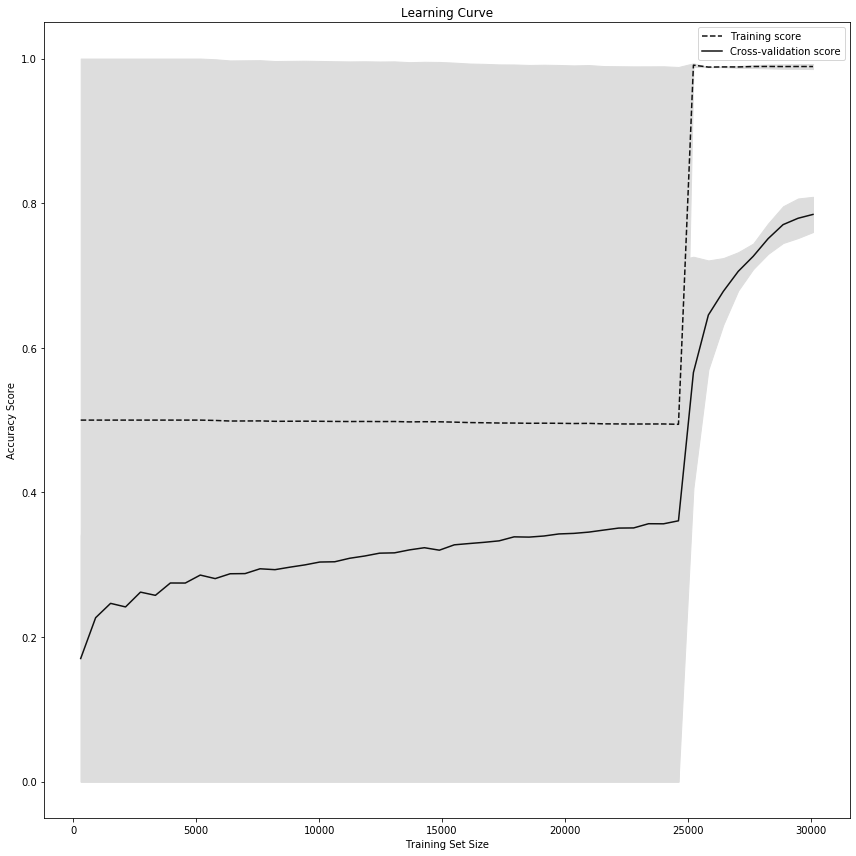

In [22]:
from sklearn.model_selection import learning_curve
plt.style.use('ggplot')
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(classifier_model1, 
                                               X_train_res, y_train_res, cv=2, scoring='f1', n_jobs=-1, 
                                               # 50 different sizes of the training set
                                       train_sizes=np.linspace(0.01, 1.0, 50)    )
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
    
# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
    
# Draw lines
plt.subplots(figsize=(12,12))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")
# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
    
# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout(); plt.show()

In [48]:
y_pred1=classifier_model1.predict(X_test)
y_pred1=pd.DataFrame(y_pred1)
y_pred1.to_csv("result1.csv",index=False)

In [16]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier_model1, X = X_train, y = y_train,scoring='f1', cv = 3,n_jobs=-1)
accuracies

array([0.44092963, 0.45530013, 0.45816099])

In [17]:
# Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
parameters = [{'subsample': [0.4,0.8], 'colsample_bytree': [0.4,0.8]}]
grid_search = GridSearchCV(estimator = classifier_model1,
                           param_grid = parameters,
                           scoring = 'f1',
                           cv = 5,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

C:\Users\Abhishek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Abhishek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
best_accuracy
best_parameters

{'colsample_bytree': 0.4, 'subsample': 0.8}

In [ ]:
[0.45821417, 0.46421786, 0.4657017 ]

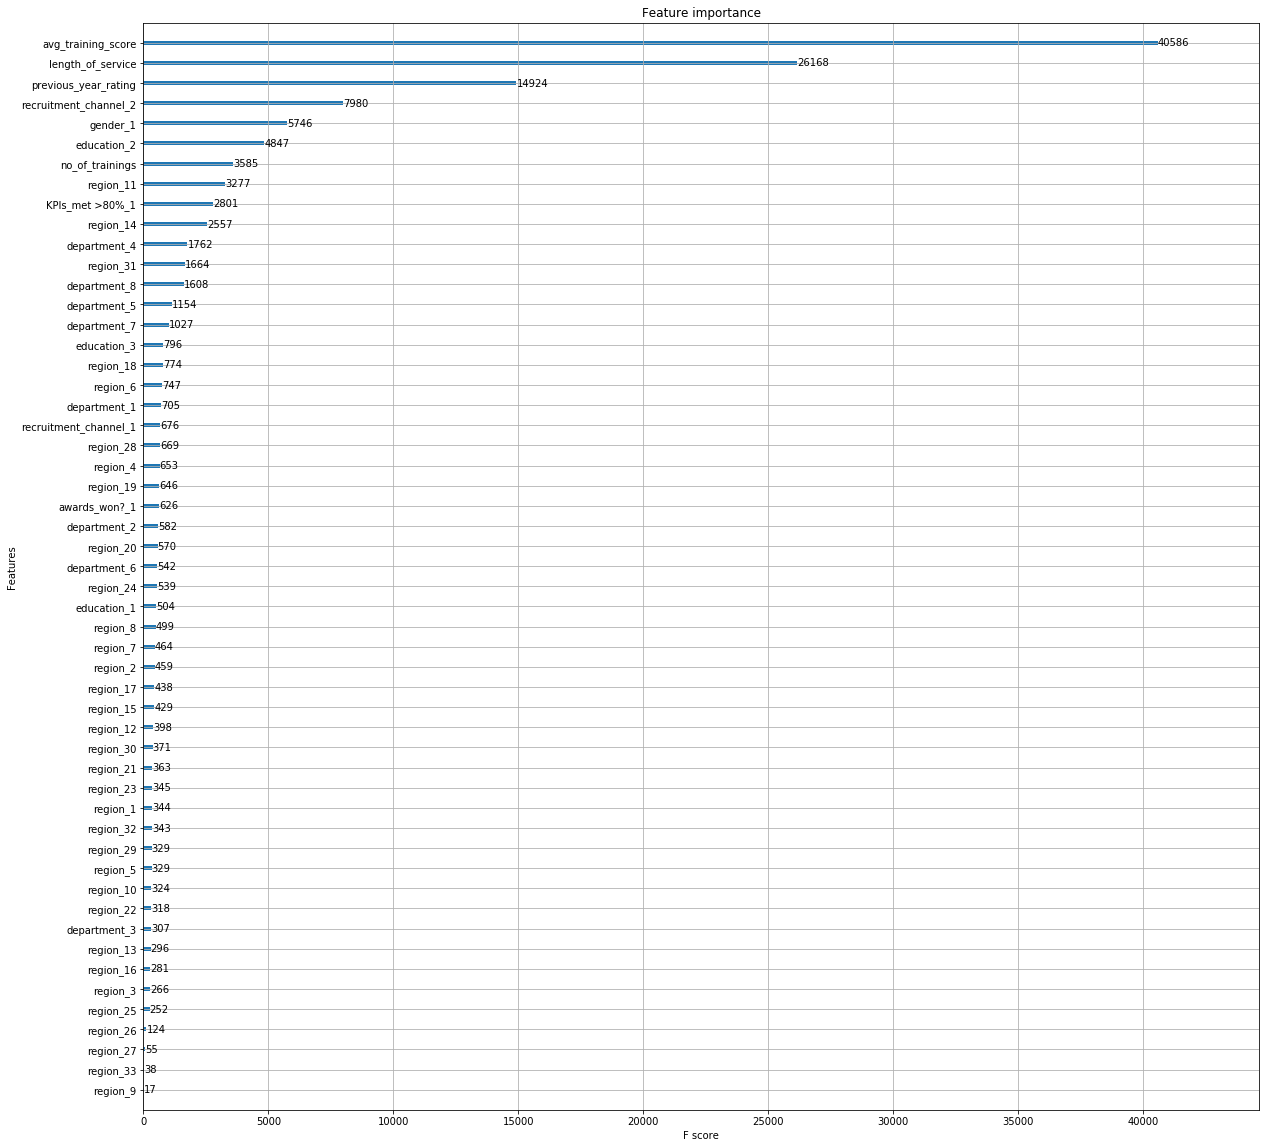

In [58]:
plt.rcParams['figure.figsize']=(20,20)
plot_importance(classifier_model1)
plt.show()

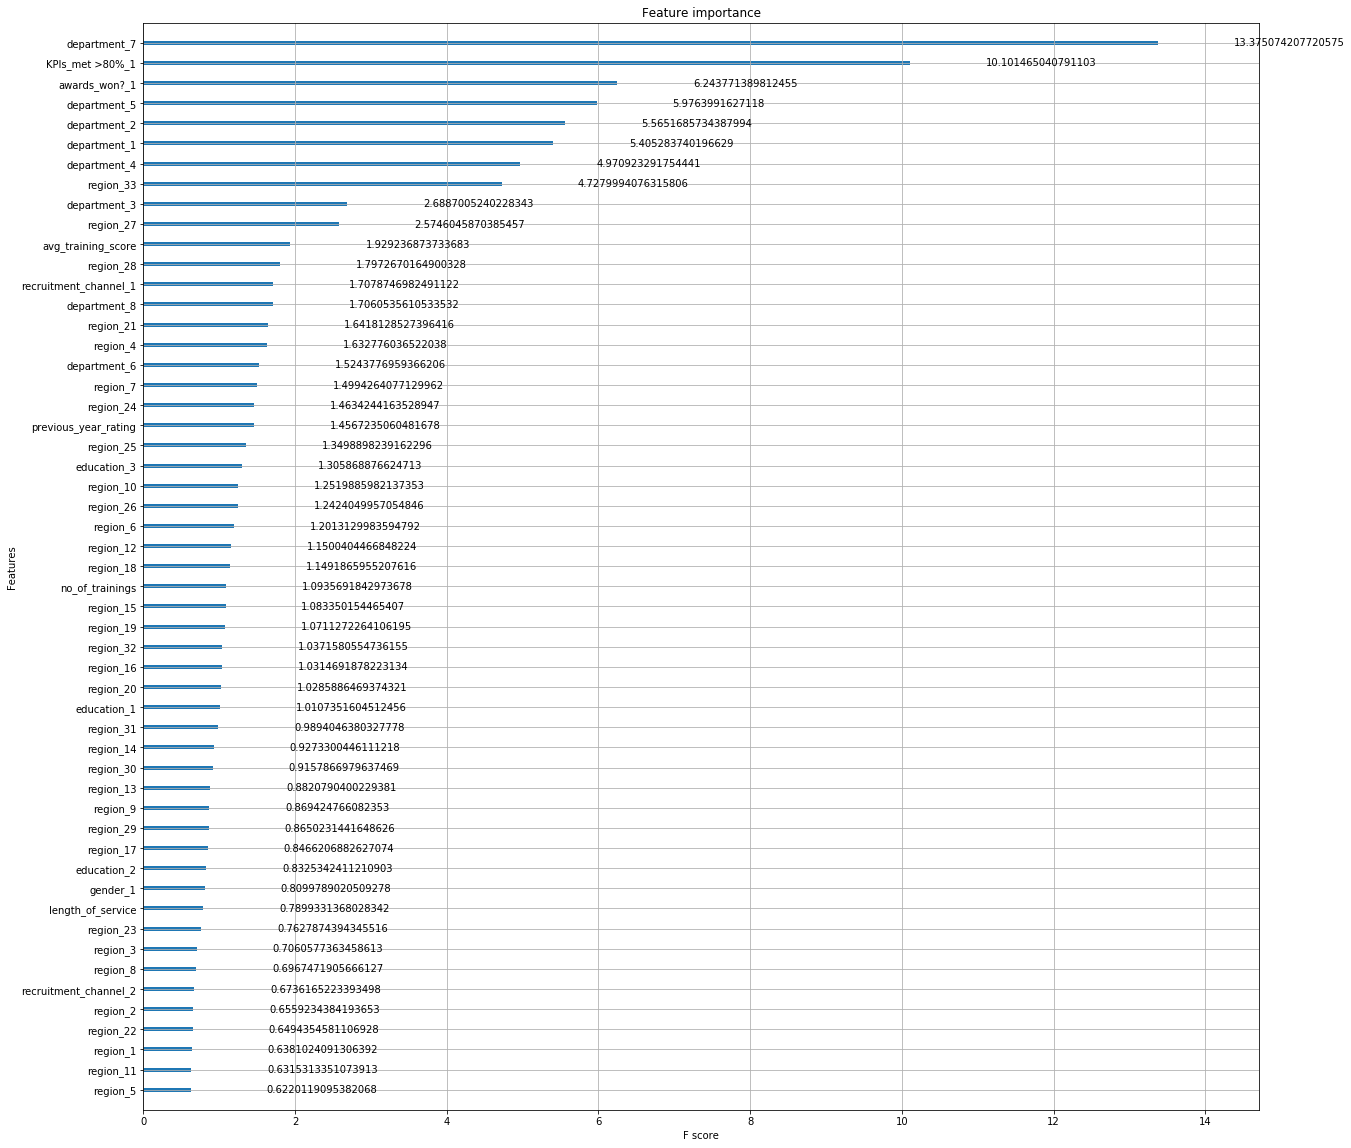

In [66]:
plt.rcParams['figure.figsize']=(20,20)
plot_importance(classifier_model1,importance_type='gain')
plt.show()

In [64]:
f = 'gain'
XGBClassifier.get_fscore(importance_type= f)

AttributeError: type object 'XGBClassifier' has no attribute 'get_fscore'

In [52]:
from xgboost import plot_importance

In [50]:
from sklearn.metrics import f1_score